In [3]:
import sys
import os
import pandas as pd
current_path = os.getcwd()
parent_dir = os.path.join(current_path, "..")
print("Current working directory:", current_path)
print("Path to the parent directory:",parent_dir)
sys.path.append(parent_dir)
import numpy as np
import astropy.units as U
from casatasks import exportfits, simobserve, tclean, gaincal, applycal
from casatools import table
from casatools import simulator as casa_simulator
import random
import shutil
from astropy.constants import c
import math
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from scipy.optimize import curve_fit
import  utility.skymodels as sku
import utility.alma as au
import utility.astro as uas
import utility.plotting as uplt
import utility.skymodels as usk

Current working directory: /home/astro/Documents/GitHub/ALMASim/experimental
Path to the parent directory: /home/astro/Documents/GitHub/ALMASim/experimental/..


0.0003236200000000001 0.00032362
1.289823739330222e-06 1.28982205e-06
1.5200000000000367e-06 1.52e-06


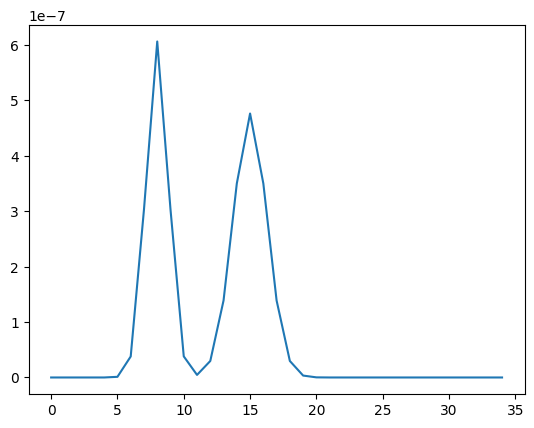

100%|██████████| 34/34 [00:00<00:00, 703.47it/s]

0.01100588982373933 0.014883019822050002


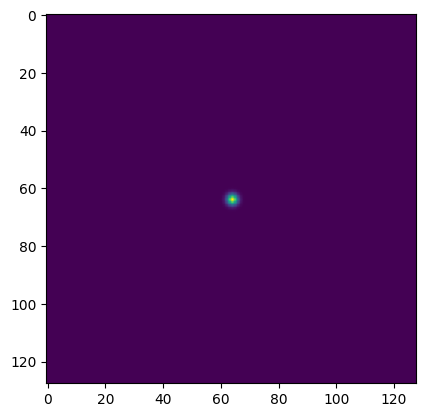

In [46]:
from scipy.integrate import quad, nquad
import numpy as np
import math
from tqdm import tqdm

from scipy.integrate import dblquad

import numpy as np
import math
from scipy.integrate import nquad
import matplotlib.pyplot as plt

def gaussian2d(x, y, amp, cen_x, cen_y, fwhm_x, fwhm_y, angle):
    """
    Generates a 2D Gaussian given the following input parameters:
    x, y: positions
    amp: amplitude
    cen_x, cen_y: centers
    fwhm_x, fwhm_y: FWHMs (full width at half maximum) along x and y axes
    angle: angle of rotation (in degrees)
    """
    angle_rad = math.radians(angle)
    
    # Rotate coordinates
    xp = (x - cen_x) * np.cos(angle_rad) - (y - cen_y) * np.sin(angle_rad) + cen_x
    yp = (x - cen_x) * np.sin(angle_rad) + (y - cen_y) * np.cos(angle_rad) + cen_y
    
    gaussian = np.exp(-((xp-cen_x)**2/(2*(fwhm_x/2.35482)**2) + (yp-cen_y)**2/(2*(fwhm_y/2.35482)**2)))
    norm = amp /  np.sum(gaussian)
    
    result = norm * gaussian
    
    return result


def gaussian(x, amp, cen, fwhm):
    """
    Generates a 1D Gaussian given the following input parameters:
    x: position
    amp: amplitude
    fwhm: fwhm
    """
    def integrand(x, amp, cen, fwhm):
        return np.exp(-(x-cen)**2/(2*(fwhm/2.35482)**2))

    integral, _ = quad(integrand, -np.inf, np.inf, args=(1, cen, fwhm))
    norm = 1 / integral
    return norm * amp * np.exp(-(x-cen)**2/(2*(fwhm/2.35482)**2))







continum = [0.00032362, 0.00032942, 0.00033533, 0.00034136, 0.00034753, 0.00035381,
        0.00036021, 0.00036672, 0.00037327, 0.00037988, 0.00038661, 0.00039345,
        0.00040031, 0.00040552, 0.00041079, 0.00041612, 0.00042153, 0.000426,
        0.00042939, 0.00043281, 0.00043626, 0.00043974, 0.00044337, 0.00044704,
        0.00045075, 0.00045449, 0.00046024, 0.00047049, 0.00048097, 0.00049168,
        0.00050263, 0.00051723, 0.00053354, 0.00055037, 0.00056773]

flux = [1.28982205e-06, 1.52e-6]
n_channels = len(continum)
cental_index = n_channels // 2
source_index = [8, 15] 
source_flux = [flux[i] + continum[source_index[i]] for i in range(len(source_index))]
source_fwhm = [2, 3]
pos_x, pos_y = 64, 64
n_px = 128
X, Y = np.meshgrid(np.arange(n_px), np.arange(n_px))
z = 0

#g1d = gaussian(idxs[0], source_flux[0], pos_x, source_fwhm[0])

g2d = gaussian2d(X, Y, continum[0], pos_x, pos_y, 3, 3, 0)

datacube = np.zeros((n_px, n_px, n_channels))
z_idxs = np.arange(0, n_channels)
gs = np.zeros(n_channels)
for i in range(len(flux)):
    gs += gaussian(z_idxs, flux[i], source_index[i], source_fwhm[i])
    print(np.sum(gaussian(z_idxs, flux[i], source_index[i], source_fwhm[i])), flux[i])
plt.figure()
plt.plot(z_idxs, gs)
plt.show() 
for z in tqdm(range(1, n_channels)):
    datacube[:, :, z] = gaussian2d(X, Y, continum[0], pos_x, pos_y, 3, 3, 0) + gaussian2d(X, Y, gs[z], pos_x, pos_y, 3, 3, 0)

print(np.sum(datacube), np.sum(continum) + np.sum(flux))

plt.figure()
plt.imshow(np.sum(datacube, axis=2))
plt.show()

plt.figure()
plt.plot(z_idxs, np.sum(datacube, axis=(0, 1)))
plt.show()

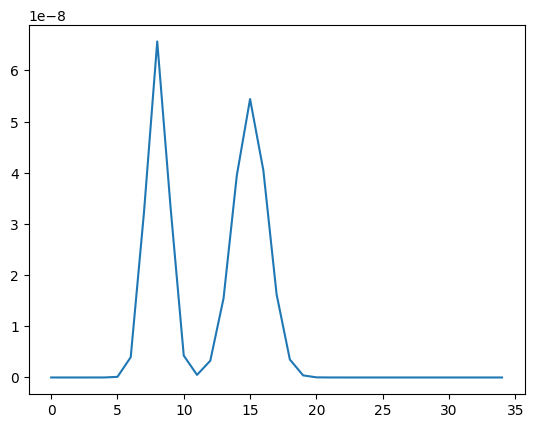

In [ ]:
import numpy as np
import math
from scipy.integrate import nquad

def gaussian2d(x, y, amp, cen_x, cen_y, fwhm_x, fwhm_y, angle):
    """
    Generates a 2D Gaussian given the following input parameters:
    x, y: positions
    amp: amplitude
    cen_x, cen_y: centers
    fwhm_x, fwhm_y: FWHMs (full width at half maximum) along x and y axes
    angle: angle of rotation (in degrees)
    """
    angle_rad = math.radians(angle)
    
    # Rotate coordinates
    xp = (x - cen_x) * np.cos(angle_rad) - (y - cen_y) * np.sin(angle_rad) + cen_x
    yp = (x - cen_x) * np.sin(angle_rad) + (y - cen_y) * np.cos(angle_rad) + cen_y
    
    def integrand(y, x, amp, cen_x, cen_y, fwhm_x, fwhm_y):
        return np.exp(-((x-cen_x)**2/(2*(fwhm_x/2.35482)**2) + (y-cen_y)**2/(2*(fwhm_y/2.35482)**2)))
    
    integral, _ = nquad(integrand, [[-np.inf, np.inf], [-np.inf, np.inf]], args=(amp, cen_x, cen_y, fwhm_x, fwhm_y))
    norm = amp / integral
    
    result = norm * np.exp(-((xp-cen_x)**2/(2*(fwhm_x/2.35482)**2) + (yp-cen_y)**2/(2*(fwhm_y/2.35482)**2)))
    
    return result